In [24]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.utils.data as Data
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F

In [25]:
device = "cuda" if torch.cuda.is_available else "cpu"
device = "cpu"
print(device)

# seed
np.random.seed(777)
torch.manual_seed(777)

# GPU seed
if device == "cuda":
    torch.cuda.manual_seed_all(777)

cpu


In [26]:
learning_rate = 0.001
training_epoch = 10
batch_size = 100

In [27]:
def make_file_list(path):
    train_img_list = list()

    with os.scandir(path) as files:
        for file in files:
            if file.name.endswith('.jpg'):
              # adds only the image files to the flowers list
                train_img_list.append(f"{path}/{file.name}")
    
    return train_img_list

In [28]:
# make train dataloader list

hot_dogs_path = r"./archive/train/hot_dog"
not_hot_dogs_path = r"./archive/train/not_hot_dog"

hot_dogs_train = make_file_list(hot_dogs_path)
not_hot_dogs_train = make_file_list(not_hot_dogs_path)

hot_dogs_train[0]

'./archive/train/hot_dog/3622018.jpg'

In [29]:
# image transform 
class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.data_transform(img)

In [30]:
from PIL import Image

# Custom Dataset
class ImageDataset(Data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        return img_transformed

In [31]:
trans = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

training_path = r"./archive/train"
test_path = r"./archive/test"
train_data = datasets.ImageFolder(root=training_path, transform=trans)
test_data = datasets.ImageFolder(root=test_path, transform=trans)


train_set = torch.utils.data.DataLoader(dataset=train_data, batch_size=100, shuffle=True)
test_set = torch.utils.data.DataLoader(dataset=test_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


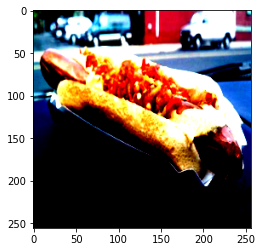

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


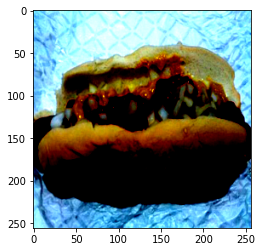

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


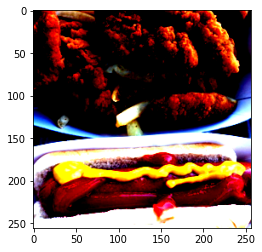

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


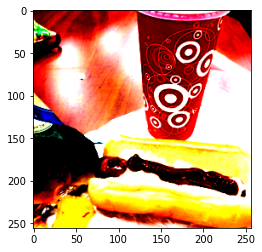

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


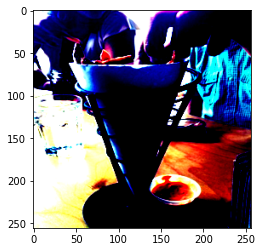

In [37]:

def show_landmarks(image, labels):
    image = image.detach().numpy()
    # image = np.reshape(256,256,3)
    print(labels)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()
# show_landmarks(next(iter(train_set))[0][0])



for batch_idx, (inputs, targets) in enumerate(train_set):
    show_landmarks(inputs[0], targets[0])    

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, 5),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = nn.Flatten()(out)
        out = self.fc(out)
        return out


In [39]:
# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=64 * 64 * 24, out_features=8*8*24)
        self.fc2 = nn.Linear(in_features=8*8*24, out_features=num_classes, bias=True)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x  = nn.Flatten()(x)
        
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        x = self.fc2(x)
        # Return class probabilities via a log_softmax function 
        return x
    

In [40]:
model = Net().to(device)

In [41]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(output, 1) == target
        running_correct = predicted.float().mean()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f} cost = {:.4f}'.format(batch_idx + 1, loss.item(),running_correct*100))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f} '.format(avg_loss))
    return avg_loss

In [42]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [44]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []


# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 3
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_set, optimizer, epoch)
        test_loss = test(model, device, test_set)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 0.698721 cost = 49.0000
	Training batch 2 Loss: 10.913417 cost = 62.0000
	Training batch 3 Loss: 90.165527 cost = 53.0000
	Training batch 4 Loss: 70.062477 cost = 42.0000
	Training batch 5 Loss: 5.959383 cost = 61.2245
Training set: Average loss: 35.559905 
Validation set: Average loss: 22.035658, Accuracy: 250/500 (50%)

Epoch: 2
	Training batch 1 Loss: 23.184074 cost = 50.0000
	Training batch 2 Loss: 18.097076 cost = 50.0000
	Training batch 3 Loss: 6.873901 cost = 57.0000
	Training batch 4 Loss: 5.636744 cost = 55.0000
	Training batch 5 Loss: 10.015992 cost = 50.0000
Training set: Average loss: 12.761558 
Validation set: Average loss: 11.604641, Accuracy: 250/500 (50%)

Epoch: 3
	Training batch 1 Loss: 8.747361 cost = 57.0000
	Training batch 2 Loss: 7.506633 cost = 49.0000
	Training batch 3 Loss: 3.901521 cost = 45.0000
	Training batch 4 Loss: 0.961821 cost = 64.0000
	Training batch 5 Loss: 2.064911 cost = 59.1837
Training set: Average

In [45]:
test_loss = test(model, device, test_set)
validation_loss.append(test_loss)

Validation set: Average loss: 3.392662, Accuracy: 252/500 (50%)



In [46]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([12, 3, 3, 3])
conv1.bias 	 torch.Size([12])
conv2.weight 	 torch.Size([24, 12, 3, 3])
conv2.bias 	 torch.Size([24])
fc.weight 	 torch.Size([1536, 98304])
fc.bias 	 torch.Size([1536])
fc2.weight 	 torch.Size([2, 1536])
fc2.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {0: {'step': 15, 'exp_avg': tensor([[[[ 1.7204e+00,  1.7821e+00,  1.6938e+00],
          [ 1.6223e+00,  1.6826e+00,  1.6334e+00],
          [ 1.4430e+00,  1.5308e+00,  1.5785e+00]],

         [[ 1.5367e+00,  1.6160e+00,  1.5166e+00],
          [ 1.4146e+00,  1.4928e+00,  1.4403e+00],
          [ 1.2032e+00,  1.3090e+00,  1.3600e+00]],

         [[ 1.1952e+00,  1.2975e+00,  1.1989e+00],
          [ 1.0489e+00,  1.1445e+00,  1.0937e+00],
          [ 8.0562e-01,  9.2368e-01,  9.8048e-01]]],


        [[[-1.0814e-01, -1.4306e-01, -1.5652e-01],
          [-6.4976e-02, -9.7551e-02, -1.2015e-01],
          [-2.3251e-02, -5.1789e-02, -7.9383e-02]],

         [[-7.8486e-02, -1

In [47]:
torch.save(model, 'model3.pt')